# Categorical Features in Regressions

I am interested in the best technique to combine continuous and categorical features in a regression model. I have two sample situations where this is important.

### Situation 1 
A ride-share business has two different rate systems: a normal price and a surge price. Their surge prices have a higher price-per-mile than their normal prices. A company that uses the ride-share often would like a model that predicts how much a ride would cost as a function of the trip distance and whether the trip is normal or under the surge price. They have collected price information from the last few months and created a plot to visualize it.


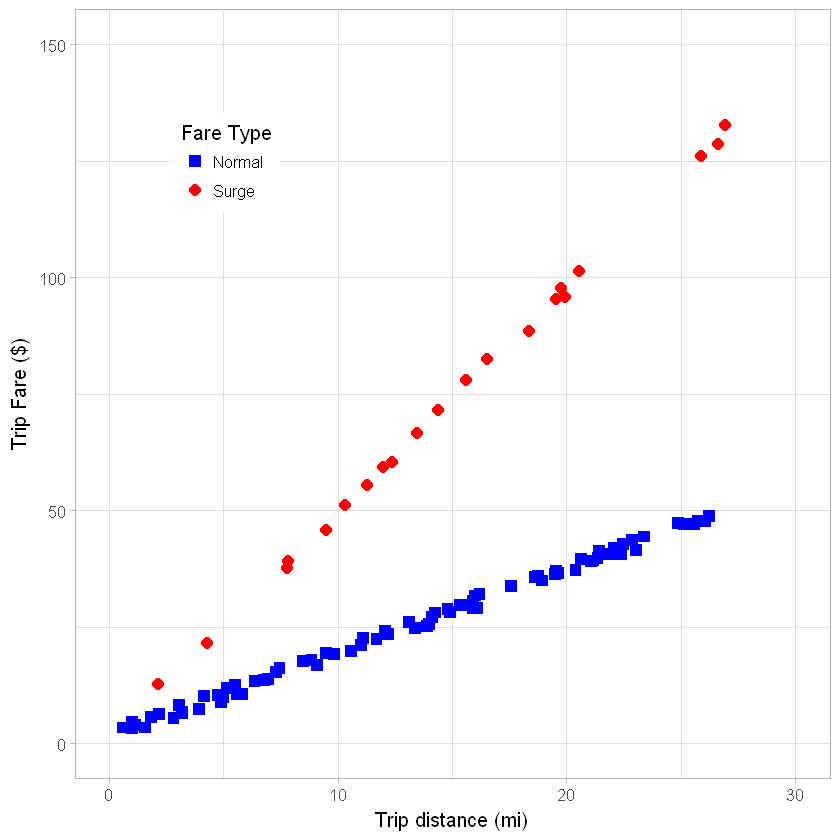

In [11]:
library(ggplot2)
library(cowplot)


n.points <- 100
trip.distance <- runif(n.points,0,27.3)
categories <- c('Normal','Surge')
slope.fare.type <- factor(categories[1*(runif(n.points,0,1) > 0.8) + 1])

slopes <- c(1.78,4.77)

slope.fare <- trip.distance * slopes[slope.fare.type] * (1 + runif(n.points,0,0.02)) + runif(n.points, 0, 3)

slope.data <- data.frame(trip.distance,slope.fare.type,slope.fare)

ggplot(slope.data) + geom_point(aes(trip.distance, slope.fare, color=slope.fare.type, shape=slope.fare.type),size=3)+
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,150) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Surge"), values=c(15,16), breaks=c("Normal","Surge")) + 
  scale_color_manual("Fare Type", values=c("Normal"="blue", "Surge"="red"), breaks=c("Normal","Surge"))

### Situation 2
A taxi company has two different types of vehicles: a normal cab and a premium (luxury) cab. The rates they charge are the same per mile, but the luxury cab has a surcharge fee that is added to the fare. A company that uses this service would like a model that predicts how much a ride would cost as a function of the trip distance using the normal cab and the luxury cab.

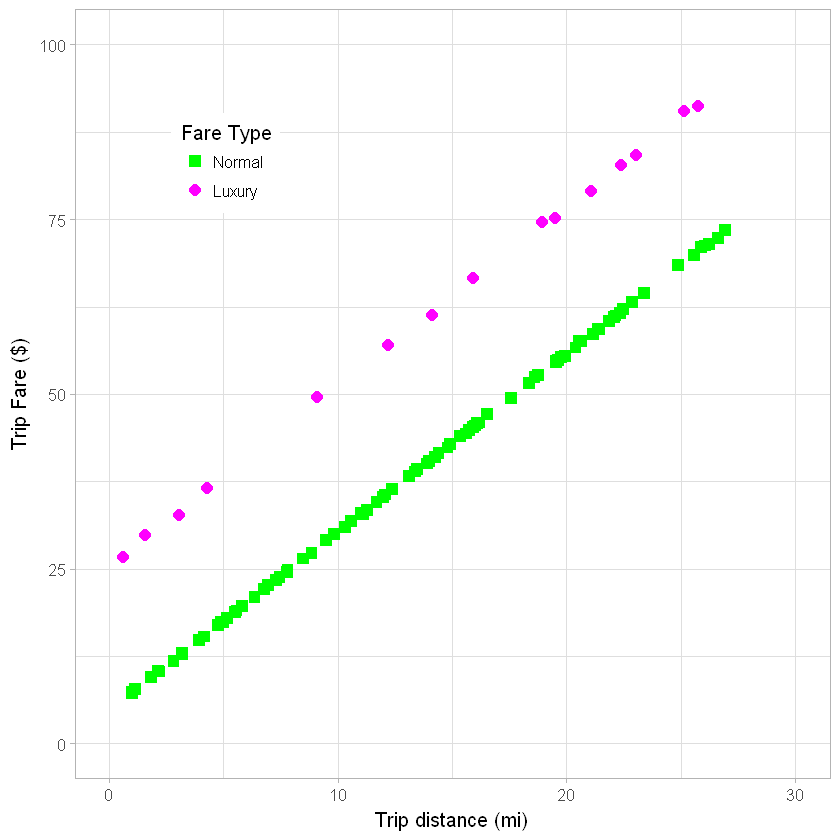

In [12]:
categories <- c('Normal','Luxury')
intercept.fare.type <- factor(categories[1*(runif(n.points,0,1) > 0.8) + 1])
intercepts <- c(8.26,1.54)

intercept.fare <- (trip.distance * (2.54 + runif(n.points,0,0.02)) + 
                  (3 + runif(n.points, 0, 0.2)) * intercepts[intercept.fare.type])

intercept.data <- data.frame(trip.distance,intercept.fare.type,intercept.fare)

ggplot(intercept.data) + geom_point(aes(trip.distance, intercept.fare, color=intercept.fare.type, shape=intercept.fare.type),size=3)+
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,100) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Luxury"), values=c(16,15), breaks=c("Normal", "Luxury")) + 
  scale_color_manual("Fare Type", values=c("Normal"="green", "Luxury"="magenta"), breaks=c("Normal", "Luxury"))

## Linear Model

I first use a straight linear model with the trip distance and fare type as the two independent variables (converting the fare type into a categorical feature first). I model the ride-share data and then predict the trip fares based on the model. If the model works, the prediction data points should like directly on top of (or very close to) the actual data points. However, they do not. This is an indicator that the linear model using the categorical feature as a simple dependent variable is not the right approach.


Warning message:
"Removed 7 rows containing missing values (geom_point)."

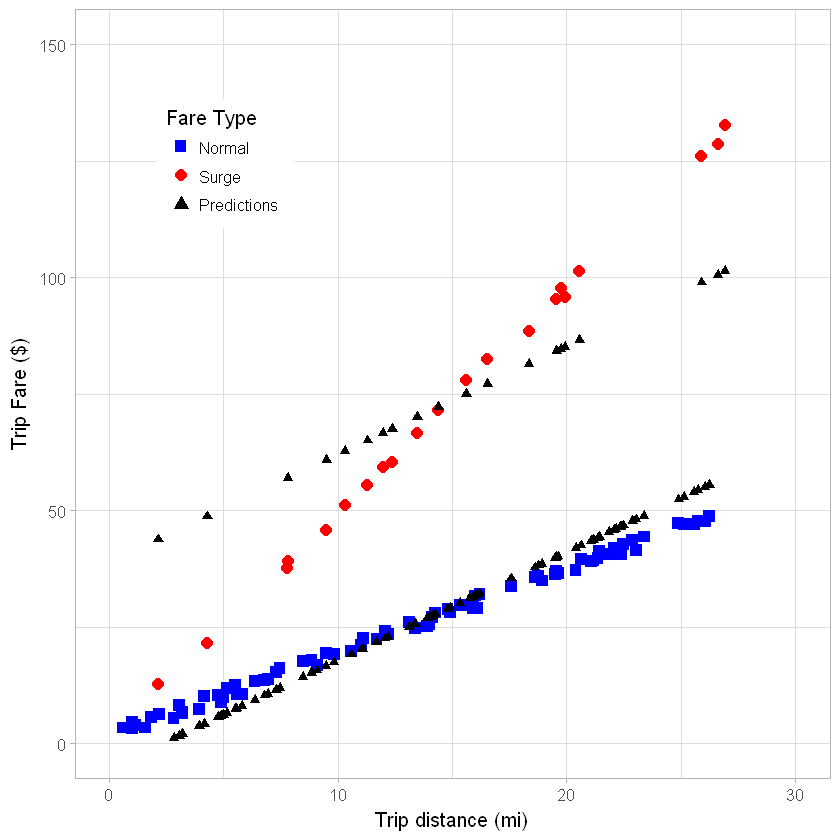

In [13]:
slope.model.1 <- lm(slope.fare ~ trip.distance + slope.fare.type, slope.data)
intercept.model.1 <- lm(intercept.fare ~ trip.distance + intercept.fare.type, intercept.data)

slope.data$slope.model1.predictions <- predict(slope.model.1,slope.data[,c('trip.distance','slope.fare.type')])
intercept.data$intercept.model1.predictions <- predict(intercept.model.1,intercept.data[,c('trip.distance','intercept.fare.type')])


ggplot(slope.data) + geom_point(aes(trip.distance, slope.fare, color=slope.fare.type, shape=slope.fare.type),size=3)+
  geom_point(aes(trip.distance, slope.model1.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,150) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Surge", "Predictions"), values=c(15,17,16), breaks=c("Normal","Surge","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="blue", "Surge"="red", "Predictions"="black"), breaks=c("Normal","Surge","Predictions"))

How about the taxi fare data? The linear model looks like it works just fine. The reason is that the different fare types correspond to different y-intercepts in the data. The effect is that the model can fit both y-intercepts separately from the slope and reach a point where the model works.

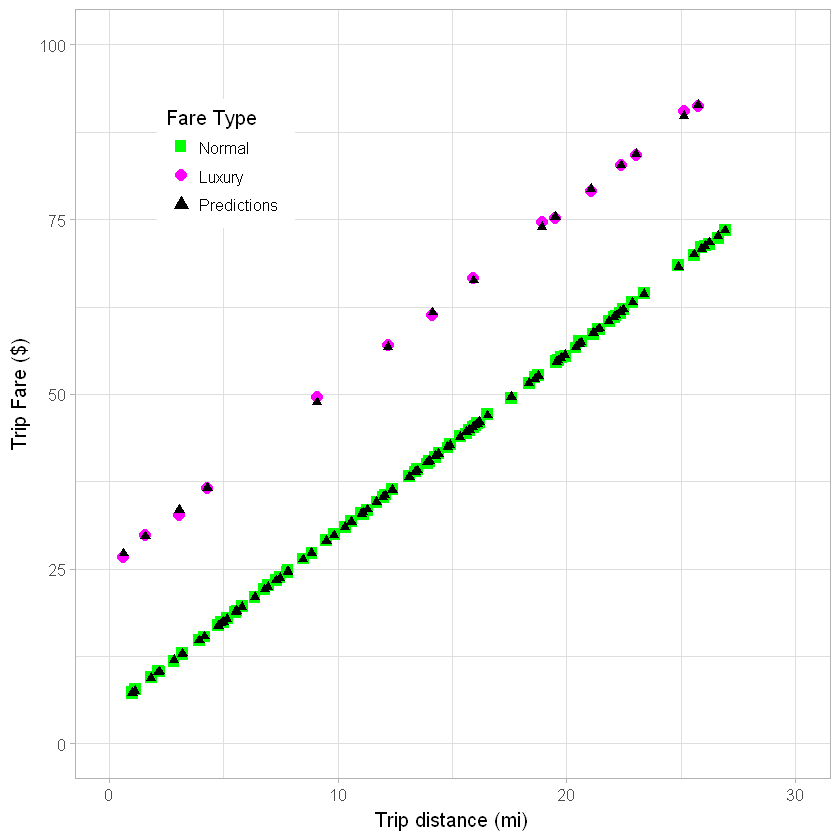

In [14]:
ggplot(intercept.data) + geom_point(aes(trip.distance, intercept.fare, color=intercept.fare.type, shape=intercept.fare.type),size=3)+
  geom_point(aes(trip.distance, intercept.model1.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,100) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Luxury", "Predictions"), values=c(16,15,17), breaks=c("Normal","Luxury","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="green", "Luxury"="magenta", "Predictions"="black"), breaks=c("Normal","Luxury","Predictions"))

## Dummy Variables

There is another approach to try: instead of using the fare type as a categorical feature with arbitrary values representing the different fare types, I split the two fare types into different feature columns which represent the two categories using binary data. This type of feature is called a dummy or one-hot feature.
![Data](table_example.jpg)
I fit the model using the trip distance and the two dummy features, but again find that the ride share model does not work.

Warning message in predict.lm(slope.model.2, slope.data[, c("trip.distance", "X.C_Normal", :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(intercept.model.2, intercept.data[, c("trip.distance", :
"prediction from a rank-deficient fit may be misleading"Warning message:
"Removed 7 rows containing missing values (geom_point)."

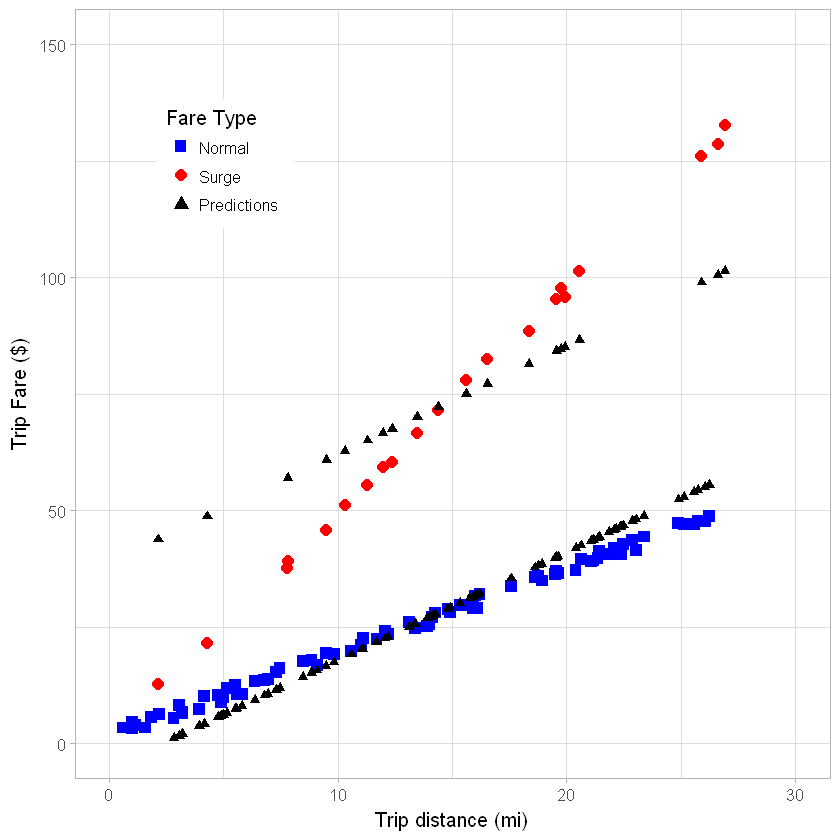

In [15]:
# One-Hot Encoding Categorical Variable


library(mlr)
# Build one-hot encoding
slope.dummydf <- createDummyFeatures(slope.data$slope.fare.type)
colnames(slope.dummydf) <- paste("X.C", colnames(slope.dummydf), sep = "_")
slope.data <- cbind(slope.data,slope.dummydf)

intercept.dummydf <- createDummyFeatures(intercept.data$intercept.fare.type)
colnames(intercept.dummydf) <- paste("X.C", colnames(intercept.dummydf), sep = "_")
intercept.data <- cbind(intercept.data,intercept.dummydf)


# new models

slope.model.2 <- lm(slope.fare ~ trip.distance +  X.C_Normal + X.C_Surge, slope.data)
intercept.model.2 <- lm(intercept.fare ~ trip.distance + X.C_Normal + X.C_Luxury, intercept.data)

slope.data$slope.model2.predictions <- predict(slope.model.2,slope.data[,c('trip.distance','X.C_Normal','X.C_Surge')])
intercept.data$intercept.model2.predictions <- predict(intercept.model.2,intercept.data[,c('trip.distance','X.C_Normal','X.C_Luxury')])


ggplot(slope.data) + geom_point(aes(trip.distance, slope.fare, color=slope.fare.type, shape=slope.fare.type),size=3)+
  geom_point(aes(trip.distance, slope.model2.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,150) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Surge", "Predictions"), values=c(15,17,16), breaks=c("Normal","Surge","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="blue", "Surge"="red", "Predictions"="black"), breaks=c("Normal","Surge","Predictions"))

On the other hand, the dummy variable approach to using categorical features works well for the taxi data. This approach to feature engineering has the same drawback as using categorical features: the model is looking for different intercepts, not different slopes.

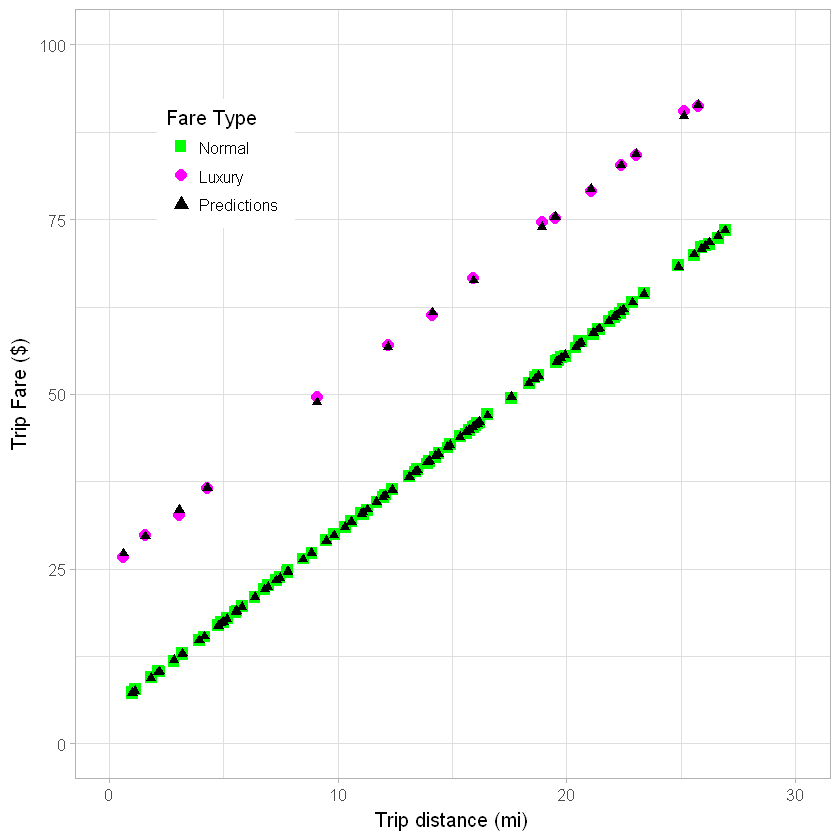

In [16]:
ggplot(intercept.data) + geom_point(aes(trip.distance, intercept.fare, color=intercept.fare.type, shape=intercept.fare.type),size=3)+
  geom_point(aes(trip.distance, intercept.model2.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,100) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Luxury", "Predictions"), values=c(16,15,17), breaks=c("Normal","Luxury","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="green", "Luxury"="magenta", "Predictions"="black"), breaks=c("Normal","Luxury","Predictions"))

What if I knew before hand that the model might have an interaction between the trip distance and the fare type? Instead of looking at a linear model where we treat the two features as independent, we could treat them as co-dependent. In this type of model, the slope is not independent of the intercept. And the model works for both cases; the predictions are fairly close to the target points.

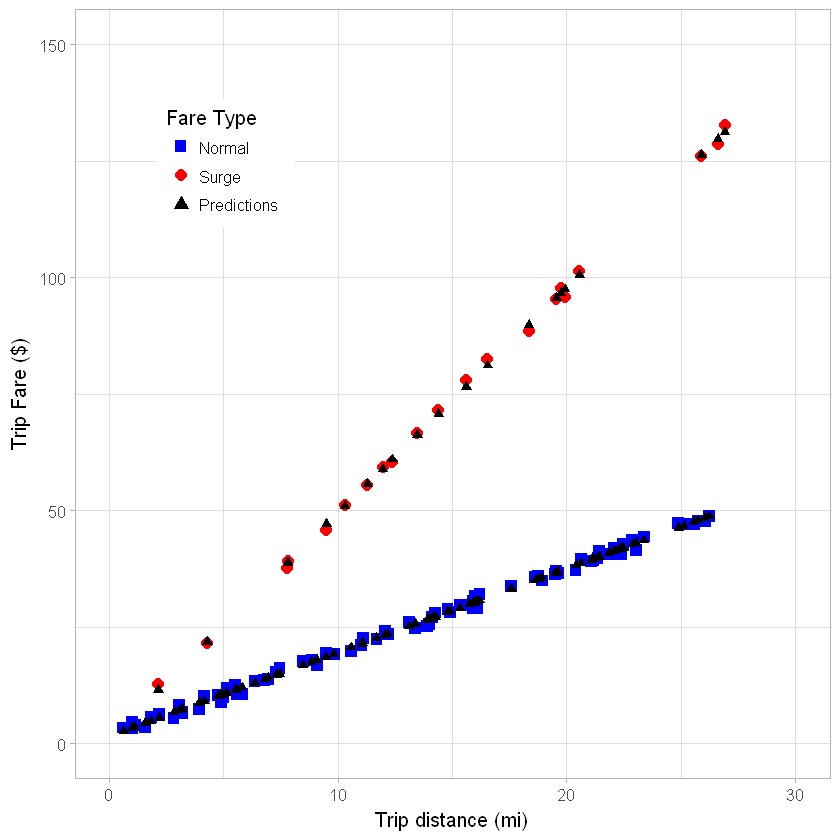

In [17]:
#Like using the categorical column directly, using the one-hot encoding works if the category impacts the intercept, but not if it impacts the slope.

# Trying to use a product of the input features instead of a sum.


slope.model.3 <- lm(slope.fare ~ trip.distance * slope.fare.type, slope.data)
intercept.model.3 <- lm(intercept.fare ~ trip.distance * intercept.fare.type, intercept.data)

slope.data$slope.model3.predictions <- predict(slope.model.3,slope.data[,c('trip.distance','slope.fare.type')])
intercept.data$intercept.model3.predictions <- predict(intercept.model.3,intercept.data[,c('trip.distance','intercept.fare.type')])


ggplot(slope.data) + geom_point(aes(trip.distance, slope.fare, color=slope.fare.type, shape=slope.fare.type),size=3)+
  geom_point(aes(trip.distance, slope.model3.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,150) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Surge", "Predictions"), values=c(15,17,16), breaks=c("Normal","Surge","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="blue", "Surge"="red", "Predictions"="black"), breaks=c("Normal","Surge","Predictions"))

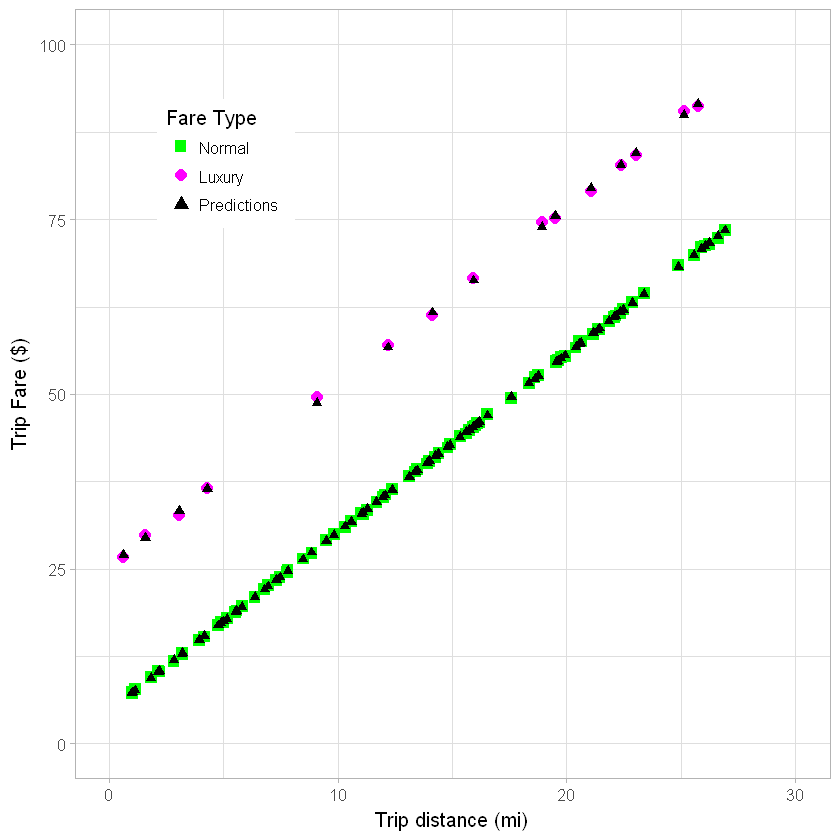

In [18]:
ggplot(intercept.data) + geom_point(aes(trip.distance, intercept.fare, color=intercept.fare.type, shape=intercept.fare.type),size=3)+
  geom_point(aes(trip.distance, intercept.model3.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,100) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Luxury", "Predictions"), values=c(16,15,17), breaks=c("Normal","Luxury","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="green", "Luxury"="magenta", "Predictions"="black"), breaks=c("Normal","Luxury","Predictions"))

## GBM
But I did not know before starting that the model was linear or that there was an interdependence between the input features. Another approach is to use a decision tree instead of a linear regression. The gradient-boosted random forest is a generalized decision tree approach with a few helpful features (model averaging, learning parameters, etc.) The drawback is that it is a non-linear model that could potentially overfit the data. There will be a trade-off between model performance and the ease of the approach. I find that both the ride-share and the taxi models fit reasonably well with a little hyperparameter tuning.


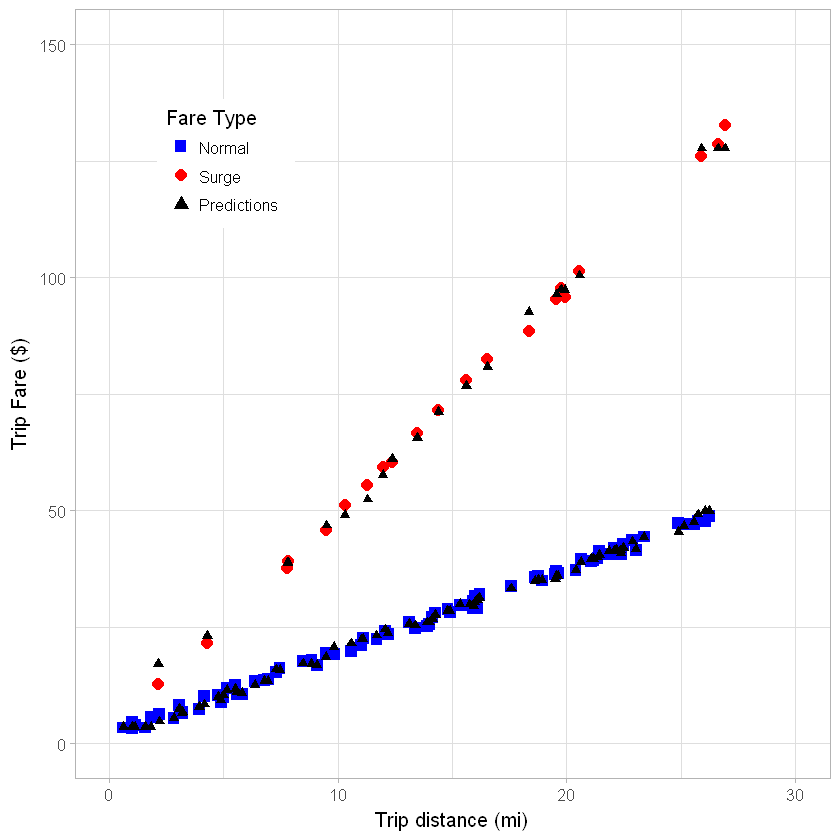

In [19]:
library(gbm)

gbm.slope.model.3 <- gbm(slope.fare ~ trip.distance + slope.fare.type, slope.data,
                  distribution = "gaussian", n.trees=500, n.minobsinnode=5, 
                  interaction.depth=2,
                  shrinkage = 0.1)

gbm.intercept.model.3 <- gbm(intercept.fare ~ trip.distance + intercept.fare.type, intercept.data, 
                  distribution = "gaussian", n.trees=500, n.minobsinnode=5, 
                  interaction.depth=2,
                  shrinkage = 0.1)


slope.data$gbm.slope.model3.predictions <- predict(gbm.slope.model.3,
                                                   slope.data[,c('trip.distance','slope.fare.type')], n.trees=500)
intercept.data$gbm.intercept.model3.predictions <- predict(gbm.intercept.model.3, 
                                                           intercept.data[,c('trip.distance','intercept.fare.type')], n.trees=500)

ggplot(slope.data) + geom_point(aes(trip.distance, slope.fare, color=slope.fare.type, shape=slope.fare.type),size=3)+
  geom_point(aes(trip.distance, gbm.slope.model3.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,150) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Surge", "Predictions"), values=c(15,17,16), breaks=c("Normal","Surge","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="blue", "Surge"="red", "Predictions"="black"), breaks=c("Normal","Surge","Predictions"))

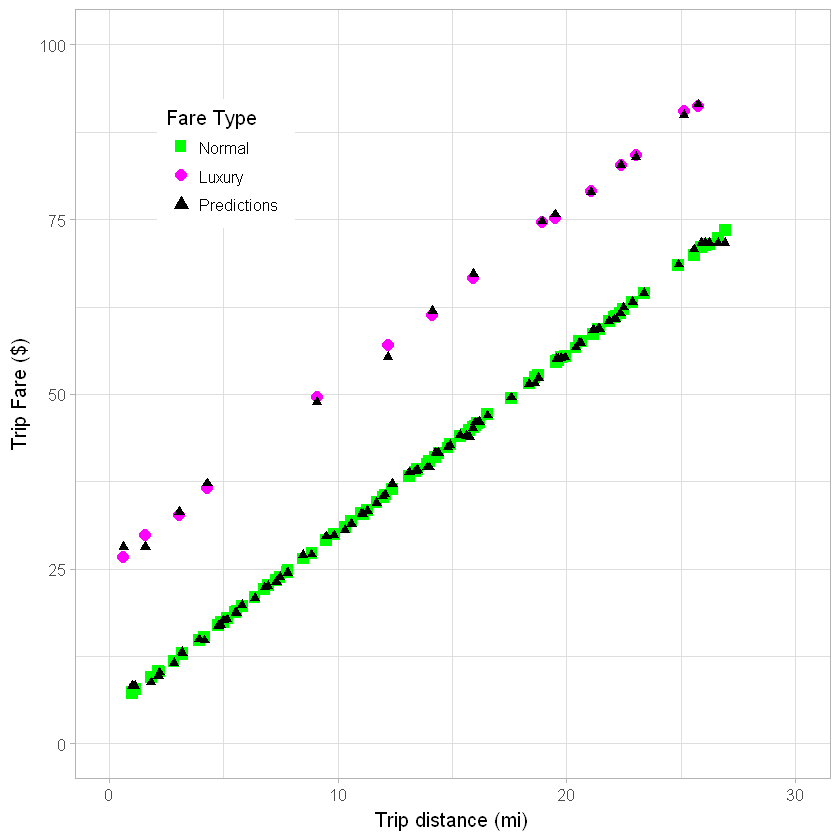

In [20]:
ggplot(intercept.data) + geom_point(aes(trip.distance, intercept.fare, color=intercept.fare.type, shape=intercept.fare.type),size=3)+
  geom_point(aes(trip.distance, gbm.intercept.model3.predictions, color="Predictions",  shape="Predictions"),size=2) +
  theme_light(base_size = 12, base_family = "") +
  xlab("Trip distance (mi)") +
  ylab("Trip Fare ($)") +
  xlim(0,30) + 
  ylim(0,100) + 
  theme(legend.position = c(0.2, 0.8)) +
  scale_shape_manual("Fare Type", labels=c("Normal", "Luxury", "Predictions"), values=c(16,15,17), breaks=c("Normal","Luxury","Predictions")) + 
  scale_color_manual("Fare Type", values=c("Normal"="green", "Luxury"="magenta", "Predictions"="black"), breaks=c("Normal","Luxury","Predictions"))



#This model works whether the categorical column impacts the slope or the intercept of the data. 

## Conclusion

Although the linear model is simple and powerful, using it with categorical features is problematic. This becomes even more problematic when there are many continuous and categorical features. An alternative approach that works well is to use a decision tree regression model. This alternative reduces the need to know before hand how the features interact. 
The notebooks (both R and Python) used in this example are available on Github (link-to-supplemental-material-section-on-ML-course-repo)
